# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [1]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

# use_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

loss_func = nn.CrossEntropyLoss()

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [2]:
def fgsm(model, x, y, eps):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function
    # model already in eval mode when this function is called
    x = x.to(device)
    y = y.to(device)
    
    x.requires_grad = True

    outputs = model(x)

    model.zero_grad()
    loss = loss_func(outputs, y).to(device)
    loss.backward()

    # Perturb the input image
    x_prime = x + eps * x.grad.sign()

    return x_prime

# k parameter can be tuned
def pgd_untargeted(model, x, y, eps_step, k=30, eps=0.3):
    #TODO: implement this
    # Notes: put the model in eval() mode for this function
    model.eval()

    x = x.to(device)
    y = y.to(device)

    ori_x = x.data

    for i in range(k) :
        adv_x = fgsm(model, x, y, eps_step)

        eta = torch.clamp(adv_x - ori_x, min=-eps, max=eps)
        x = torch.clamp(ori_x + eta, min=0, max=1).detach_()

    return x

# Implement Adversarial Training

In [30]:
# for now, make maximum pertubation allowed 0.3

def train_model(model, num_epochs, enable_defense=True, attack='pgd', eps=0.1):
    # TODO: implement this function that trains a given model on the MNIST dataset.
    # this is a general-purpose function for both standard training and adversarial training.
    # (toggle enable_defense parameter to switch between training schemes)
    optimizer = optim.SGD(model.parameters())

    model.train()

    for epoch in range(num_epochs):
      # code adapted from official pytorch guide here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
      # running_loss = 0.0
      for i, (inputs, labels) in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          # inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          if enable_defense:
            # Generate adversarial examples using PGD
            adv_inputs = pgd_untargeted(model, inputs, labels, eps)
            # have the model train on these instead
            inputs = torch.cat([inputs, adv_inputs])
            labels = torch.cat([labels, labels])
            # put the model back in training mode
            model.train()

          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = loss_func(outputs, labels)
          loss.backward()
          optimizer.step()

          # # print statistics
          # running_loss += loss.item()
          # if i % 2000 == 1999:    # print every 2000 mini-batches
          #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
          #     running_loss = 0.0

In [25]:
def test_model(model, attack='non', eps=0.1):
    # TODO: implement this function to test the robust accuracy of the given model
    # use pgd_untargeted() within this function

    # loss_func = nn.CrossEntropyLoss()

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    for test_inputs, true_labels in test_loader:
        # if testing on attacks, get adversarial examples for robust accuracy
        test_inputs = test_inputs.to(device)
        true_labels = true_labels.to(device)

        if attack == 'pgd':
            adv_inputs = pgd_untargeted(model, test_inputs, true_labels, eps)
            # test_inputs = torch.cat([test_inputs, adv_inputs])
            # true_labels = torch.cat([true_labels, true_labels])
            test_inputs = adv_inputs
        elif attack == 'fgsm':
            adv_inputs = fgsm(model, test_inputs, true_labels, eps)
            test_inputs = adv_inputs

        # Forward pass
        output = model(test_inputs)
        test_loss += loss_func(output, true_labels).item()  # Sum up batch loss

        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

        correct += pred.eq(true_labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    if attack != 'non':
      print(f"Test set: Average loss: {test_loss:.4f}, Robust Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")
    else:
      print(f"Test set: Average loss: {test_loss:.4f}, Regular Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")
    return accuracy

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [5]:
## train the original model
model = nn.Sequential(Normalize(), Net())
model = model.to(device)
model.train()

train_model(model, 20, False)
torch.save(model.state_dict(), 'weights.pt')

In [15]:
## perform PGD attack and construct adversarial example set
adversarial_set = set()

for test_inputs, true_labels in test_loader:
        # if testing on attacks, get adversarial examples for robust accuracy
        test_inputs = test_inputs.to(device)
        true_labels = true_labels.to(device)

        adv_inputs = pgd_untargeted(model, test_inputs, true_labels, 0.05)

        random_index = np.random.randint(0, len(test_inputs))

        img1 = torch.Tensor.cpu(test_inputs[random_index]).detach().numpy()[0]
        img2 = torch.Tensor.cpu(adv_inputs[random_index]).detach().numpy()[0]

        break

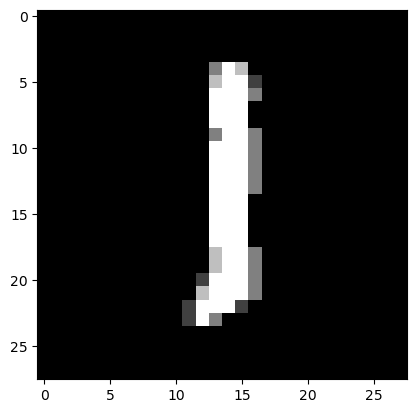

In [16]:
plt.imshow(img1, cmap='gray')

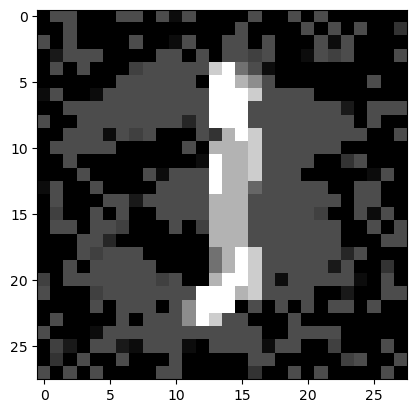

In [18]:
plt.imshow(img2, cmap='gray')

In [11]:
## model without attack
model = nn.Sequential(Normalize(), Net()).to(device)
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model(model, attack='non', eps=eps)

C:\Users\haoli\AppData\Local\Temp\ipykernel_21736\2054948134.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights.pt'))


Test set: Average loss: 0.0041, Regular Accuracy: 9249/10000 (92.49%)
Test set: Average loss: 0.0041, Regular Accuracy: 9249/10000 (92.49%)
Test set: Average loss: 0.0041, Regular Accuracy: 9249/10000 (92.49%)
Test set: Average loss: 0.0041, Regular Accuracy: 9249/10000 (92.49%)


In [9]:
## PGD attack on regular model
model = nn.Sequential(Normalize(), Net()).to(device)
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model(model, attack='pgd', eps=eps)

C:\Users\haoli\AppData\Local\Temp\ipykernel_21736\3501405878.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights.pt'))


Test set: Average loss: 0.1798, Robust Accuracy: 0/10000 (0.00%)
Test set: Average loss: 0.1794, Robust Accuracy: 0/10000 (0.00%)
Test set: Average loss: 0.1784, Robust Accuracy: 0/10000 (0.00%)
Test set: Average loss: 0.1766, Robust Accuracy: 0/10000 (0.00%)


In [29]:
## FGSM attack on regular model
model = nn.Sequential(Normalize(), Net()).to(device)
model.load_state_dict(torch.load('weights.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    test_model(model, attack='fgsm', eps=eps)

C:\Users\haoli\AppData\Local\Temp\ipykernel_21736\1248948121.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights.pt'))


Test set: Average loss: 0.0243, Robust Accuracy: 4830/10000 (48.30%)
Test set: Average loss: 0.0707, Robust Accuracy: 530/10000 (5.30%)
Test set: Average loss: 0.1245, Robust Accuracy: 23/10000 (0.23%)
Test set: Average loss: 0.1739, Robust Accuracy: 0/10000 (0.00%)


In [31]:
## PGD based adversarial training
model = nn.Sequential(Normalize(), Net()).to(device)
eps = 0.1
train_model(model, 20, True, 'pgd', eps)
torch.save(model.state_dict(), f'weights_AT_0.1.pt')

In [19]:
## adversarial model without attack
model = nn.Sequential(Normalize(), Net()).to(device)
model.load_state_dict(torch.load(f'weights_AT_0.1.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    print(f"testing adversarial-trained model with eps {eps}")
    test_model(model, attack='non', eps=eps)

C:\Users\haoli\AppData\Local\Temp\ipykernel_21736\3782126206.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights_AT_0.1.pt'))


testing adversarial-trained model with eps 0.05
Test set: Average loss: 0.0109, Regular Accuracy: 8713/10000 (87.13%)
testing adversarial-trained model with eps 0.1
Test set: Average loss: 0.0109, Regular Accuracy: 8713/10000 (87.13%)
testing adversarial-trained model with eps 0.15
Test set: Average loss: 0.0109, Regular Accuracy: 8713/10000 (87.13%)
testing adversarial-trained model with eps 0.2
Test set: Average loss: 0.0109, Regular Accuracy: 8713/10000 (87.13%)


In [20]:
## PGD attack on adversarial trained model
model = nn.Sequential(Normalize(), Net()).to(device)
model.load_state_dict(torch.load(f'weights_AT_0.1.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    print(f"testing adversarial-trained model with eps {eps}")
    test_model(model, attack='pgd', eps=eps)

C:\Users\haoli\AppData\Local\Temp\ipykernel_21736\788659330.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights_AT_0.1.pt'))


testing adversarial-trained model with eps 0.05
Test set: Average loss: 0.0407, Robust Accuracy: 664/10000 (6.64%)
testing adversarial-trained model with eps 0.1
Test set: Average loss: 0.0399, Robust Accuracy: 954/10000 (9.54%)
testing adversarial-trained model with eps 0.15
Test set: Average loss: 0.0392, Robust Accuracy: 1058/10000 (10.58%)
testing adversarial-trained model with eps 0.2
Test set: Average loss: 0.0385, Robust Accuracy: 1247/10000 (12.47%)


In [28]:
## FGSM attack on adversarial trained model
model = nn.Sequential(Normalize(), Net()).to(device)
model.load_state_dict(torch.load(f'weights_AT_0.1.pt'))

for eps in [0.05, 0.1, 0.15, 0.2]:
    print(f"testing adversarial-trained model with eps {eps}")
    test_model(model, attack='fgsm', eps=eps)

C:\Users\haoli\AppData\Local\Temp\ipykernel_21736\2114601599.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weights_AT_0.1.pt'))


testing adversarial-trained model with eps 0.05
Test set: Average loss: 0.0178, Robust Accuracy: 6741/10000 (67.41%)
testing adversarial-trained model with eps 0.1
Test set: Average loss: 0.0254, Robust Accuracy: 4455/10000 (44.55%)
testing adversarial-trained model with eps 0.15
Test set: Average loss: 0.0319, Robust Accuracy: 2943/10000 (29.43%)
testing adversarial-trained model with eps 0.2
Test set: Average loss: 0.0376, Robust Accuracy: 1972/10000 (19.72%)
